In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import copy as cp
import pandas as pd
import countryinfo
import geopandas as gpd
from timeit import default_timer as timer # try to measure time
from climada.engine import Impact
from climada.entity import ImpactFunc,ImpactFuncSet
from os import mkdir, remove, rmdir


In [2]:
##function definition
from functions import *
from climada_functions import *
from constants import * 

In [3]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=5E5
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season

bn = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
bn_proc = make_fn(processings,bn)


# Exposure

In [5]:
#import exposure data (already preprocessed)
from climada.entity import Exposures
from climada import CONFIG
results = CONFIG.local_data.save_dir.dir()
exp = Exposures.from_hdf5(results.joinpath(('exposures/exp_crpd_EU_600.h5')))
exp.check()


/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'LitPop Exposure for Europe, 2018\nProduced capital')

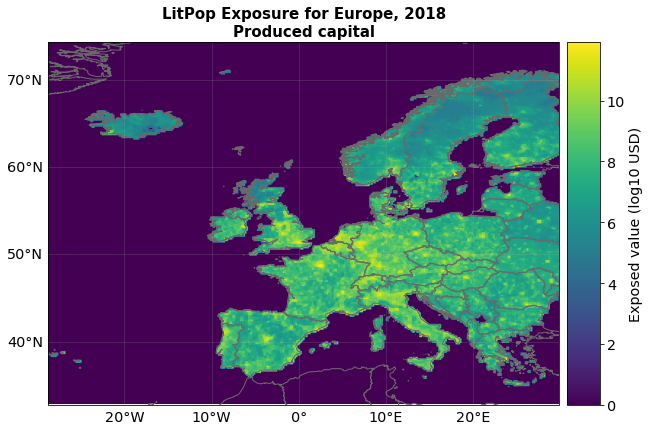

In [6]:
#ax = exp.plot_hexbin(pop_name=False,vmin=1E7,vmax=1E11
ax = exp.plot_raster(label='Exposed value (log10 USD)')

ax.set_title('LitPop Exposure for Europe, 2018\nProduced capital',fontsize=15,fontweight="bold")
#plt.savefig(savefigpath+'/Exposures/hexbin_exp_cropped600EU.png',transparent=False)

# Main calculation cell
Use stack=True to stack model members on top of each other, set stack=False to consider each member separately.
Use savehaz, saveimpcsv, saveimpmat to save hazards or/and imapcts.
1) Loop over impact functions
2) Loop over scenarios
3) Loop over climate models
4) Loop over model members


In [7]:
scenlist

['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

In [8]:
modlist_allscen

['CanESM5',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'UKESM1-0-LL',
 'MRI-ESM2-0',
 'FGOALS-g3',
 'ACCESS-ESM1-5',
 'MIROC6',
 'MPI-ESM1-2-LR',
 'KACE-1-0-G']

In [7]:
#load impfset
impf_set_uncal = ImpactFuncSet()
impf_set_uncal.read_excel(pathcal+"diff_impfset.csv")
pp_func_dic = pp_func_dic_diff
impf_dict = {}
impf_set_dict = {}
impf_namelist = []
for ifid, impf in impf_set_uncal.get_func()['WS'].items():
    impf_name = impf.name
    impf_namelist.append(impf_name)
    impf_dict[impf_name] = [ifid,impf]
    new_impfset = ImpactFuncSet()
    new_impf = cp.deepcopy(impf)
    new_impf.id = 0 
    new_impfset.append(new_impf)
    impf_set_dict[impf_name] = new_impfset


2022-08-17 09:28:19,508 - climada.entity.impact_funcs.impact_func_set - WARNING - The use of ImpactFuncSet.read_excel is deprecated.Use ImpactFuncSet.from_excel instead.
2022-08-17 09:28:20,053 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-08-17 09:28:20,054 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-08-17 09:28:20,055 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


array([<AxesSubplot:title={'center':'WS 1: Cubic excess-over-threshold'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 2: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 3: Schwierz 2010'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>],
      dtype=object)

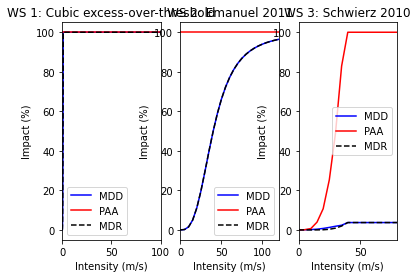

In [44]:
impf_set_uncal.plot()

In [45]:
impf_namelist

['Cubic excess-over-threshold', 'Emanuel 2011', 'Schwierz 2010']

In [17]:
#select climate models, used scenarios (historical, ssp585,...), impact functions and calibration type
modlist =  modlist_ssp585
impf_used = impf_namelist
scen_used= ['historical','ssp585']
pastname = 'historical'
timeres='day'
nmems = 3
caltype = 'AAI_EMDAT_100mn'

In [18]:
#initiate df to save results
metrics = ["AAI_agg","45 yr impact","90 yr impact"]
itercol = [scen_used,metrics]
col_idx = pd.MultiIndex.from_product(itercol,names=["scenario","metric"])
iterrows = [modlist,range(nmems)]
row_idx= pd.MultiIndex.from_product(iterrows,names=["model","member"])


In [19]:
#select calibration file 
bn_proc_cal = bn_proc
bn_cal = bn_proc_cal+'_allmods'
calname = make_fn(["cal",caltype],bn_cal,filetype=".csv")

In [20]:
##main calculation cell.
#Loop over impact functions, scenarios, models and model members
#Use stack=True to stack model members on top of each other, set stack=False to consider each member separately.
#Use savehaz, saveimpcsv, saveimpmat to save hazards or/and imapcts.

##parameters
stack = False #stack members
savehaz = False #save hazard file
saveimpmat = False #save impact matrix
saveimpcsv = True #save impact csv
savestats = True #save write stats in a pandas dataframe
test = '' #add extra to file savenames
if_id = 0 #default value of the impact function; 0 for uncalibrated impact function
it = 0 #iteration count
df_list = []
impf_keys = []

    
for impfi in impf_used:
    #initiate df
    if stack:
        res_df = pd.DataFrame(columns=col_idx,index=modlist)
    else:
        res_df = pd.DataFrame(columns=col_idx,index=row_idx)
    
    
    # get impf_set 
    impf_seti = impf_set_dict[impfi]
    
    for scen in scen_used:
        for modid, modname in enumerate(modlist):
    
            #read netcdf
            fn = make_fn([modname],bn,filetype=".nc")
            ncdf = xr.open_dataset(pathinvar+fn)
            ncdfw = ncdf[[pastname,scen]]
            latres, lonres = get_lat_lon_res(ncdf)
            latout = ncdf.lat
            lonout = ncdf.lon
            #select number of members to be considered
            if stack:
                nmems=1
            else:
                nmems = len(ncdf.member)
                
            #apply gust factor
            gust_ds = gst_fact*ncdfw
            
            # get names
            impf_namesht = impf_sht_names[impfi]
            pp_funcname = str(pp_func_dic[impfi]).split(" ")[1]
            savenamehaz = make_fn([pp_funcname],bn_proc)
            savenameimp = make_fn([impf_namesht,caltype,pp_funcname],bn_proc)
            
            #calibrate impf
            if caltype!='nocal':
                paramspath = pathcal+calname
                param = pd.read_csv(paramspath,header=[0],index_col=0).loc[modname,impfi]
                impf_seti = tune_impf(impf_seti,param,modname,plot=False)
                if_id = 1
            

            #iterate over the members
            for imem in range(nmems):
                start_time = timer()
                #preprocess fields
                if stack:
                    mem_da = gust_ds
                else: 
                    mem_da = gust_ds.sel(member=imem)
            
                preprocess_func = pp_func_dic[impfi]
                gust_pp = preprocess_func(mem_da,qt,cutarea=cut,timeres=timeres,pastname=pastname,futname=scen,stack=stack)
                if scen != 'historical':
                    gust_pp_sel = gust_pp[scen]
                else:
                    gust_pp_sel = gust_pp
                
                #prepare hazards centroids
                haz = set_centroids(gust_pp_sel,stack=stack,timeres=timeres,plot=False)
                if impf_namesht == 'CubEOT':
                    max_int =  haz.intensity.max()
                    if max_int >= 1:
                        print("*"*100+'\n\n'+' '*25+'/!\ max_int = '+str(max_int)+' for model '+modname+'\n\n'+"*"*100)
                
                
                # deepcopy exposure before assigning centroids
                exp_sel = cp.deepcopy(exp)
                # Exposures: rename column and assign id
                exp_sel.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
                exp_sel.gdf['impf_' + haz_type] = if_id
                
                ####### dummy exposure
                #exp_sel.gdf.value = 1000
                #test = 'stepexp' # step exposure


                #assign centroids
                #exp_sel.assign_centroids(haz,distance='approx',threshold=300)
                dist_th = np.sqrt((latres*100)**2 + (lonres*100)**2)
                exp_sel.assign_centroids(haz,distance='euclidean',threshold=dist_th)
                exp_sel.check()
                
                #compute impacts
                #past
                imp = Impact()
                imp.calc(exp_sel, impf_seti, haz, save_mat=saveimpmat) #Do not save the results geographically resolved (only aggregate values)
                
                #save results
                if savestats:
                    #compute freq curves 
                    imp45 = imp.calc_freq_curve(return_per=45).impact 
                    imp90 = imp.calc_freq_curve(return_per=90).impact 
                    if stack:
                        res_df.loc[modname,(scen,"AAI_agg")] = imp.aai_agg
                        res_df.loc[modname,(scen,"45 yr impact")] = imp45
                        res_df.loc[modname,(scen,"90 yr impact")] = imp90
                    else: 
                        res_df.loc[(modname,imem),(scen,"AAI_agg")] = imp.aai_agg
                        res_df.loc[(modname,imem),(scen,"45 yr impact")] = imp45
                        res_df.loc[(modname,imem),(scen,"90 yr impact")] = imp90
                
                ##save files
                
                if stack:
                    simname = 'stacked'
                    savesubdir = 'stacked/'+scen+'/'
                else:
                    simname = 'nmem'+str(imem)
                    savesubdir = 'memsep/'+scen+'/'

                
                #save hazards
                if savehaz:
                    try:
                        haz.write_hdf5(pathhaz+savesubdir+make_fn(['haz',simname,scen,modname],savenamehaz,filetype='.h5'))
                    except FileNotFoundError:
                        mkdir(pathhaz+savesubdir)
                        haz.write_hdf5(pathhaz+savesubdir+make_fn(['haz',simname,scen,modname],savenamehaz,filetype='.h5'))
                #save impacts
                if saveimpcsv:
                    try:
                        #rmdir(pathimp+'impact csv/memsep/'+scen+"/")
                        #mkdir(pathimp+'impact csv/memsep/'+scen+"/")
                        imp.write_csv(pathimp+'impact csv/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.csv'))
                    except FileNotFoundError:
                        mkdir(pathimp+'impact csv/aggregated/'+savesubdir)
                        imp.write_csv(pathimp+'impact csv/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.csv'))
                if saveimpmat:
                    try:
                        #rmdir(pathimp+'impact matrices/'+savesubdir)
                        #mkdir(pathimp+'impact matrices/'+savesubdir)
                        imp.write_sparse_csr(pathimp+'impact matrices/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.npz'))
                    except FileNotFoundError:
                        mkdir(pathimp+'impact matrices/aggregated/'+savesubdir)
                        imp.write_sparse_csr(pathimp+'impact matrices/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.npz'))
                #delete haz, imp and ep  objects
                #del haz
                #del imp
                #del exp_sel
                
                time_delta_past = timer() - start_time
                print(time_delta_past)
                
        it = it+1       

    res_df = res_df.astype(np.float64)
    impf_keys.append(impf_namesht)
    df_list.append(res_df)

res_df_all = pd.concat(df_list,keys=impf_keys,axis=1,names=("Impf","scenario","metric"))

7.218933805823326
****************************************************************************************************

                         /!\ max_int = 1.3647537472836784 for model BCC-CSM2-MR

****************************************************************************************************
1.1940939091145992
****************************************************************************************************

                         /!\ max_int = 1.055910093539173 for model CNRM-CM6-1-HR

****************************************************************************************************
17.689930502325296
****************************************************************************************************

                         /!\ max_int = 1.4111661541904184 for model EC-Earth3-CC

****************************************************************************************************
9.102244295179844
************************************************************************